# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

default_shared_diagnosis_generation_to_upload_days = 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_download_only_from_report_backend = \
    os.environ.get("RADARCOVID_REPORT__DOWNLOAD_ONLY_FROM_REPORT_BACKEND")
if environment_download_only_from_report_backend:
    report_backend_identifiers = [report_backend_identifier]
else:
    report_backend_identifiers = None

report_backend_identifiers

In [6]:
environment_shared_diagnosis_generation_to_upload_days = \
    os.environ.get("RADARCOVID_REPORT__SHARED_DIAGNOSIS_GENERATION_TO_UPLOAD_DAYS")
if environment_shared_diagnosis_generation_to_upload_days:
    shared_diagnosis_generation_to_upload_days = \
        int(environment_shared_diagnosis_generation_to_upload_days)
else:
    shared_diagnosis_generation_to_upload_days = \
        default_shared_diagnosis_generation_to_upload_days

shared_diagnosis_generation_to_upload_days

2

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe_from_ecdc():
    return pd.read_csv(
        "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

confirmed_df_ = download_cases_dataframe_from_ecdc()

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
41158,2020-11-03,0,LC
30870,2020-11-03,28,ML
21764,2020-11-03,0,HT
22227,2020-11-03,193,HN
0,2020-11-03,95,AF


In [10]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
source_regions_at_date_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
source_regions_at_date_df["source_regions_at_date"] = \
    source_regions_at_date_df.sample_date.apply(
        lambda x: report_backend_client.source_regions_for_date(date=x))
source_regions_at_date_df.sort_values("sample_date", inplace=True)
source_regions_at_date_df.tail()

,sample_date,source_regions_at_date
304,2020-10-30,"{IE, LV, DE, IT, ES}"
305,2020-10-31,"{IE, LV, DE, IT, ES}"
306,2020-11-01,"{IE, LV, DE, IT, ES}"
307,2020-11-02,"{IE, LV, DE, IT, ES}"
308,2020-11-03,"{IE, LV, DE, IT, ES}"


In [11]:
confirmed_df = source_regions_at_date_df.merge(confirmed_df, how="left")
confirmed_df = confirmed_df[confirmed_df.apply(
    lambda x: x.country_code in x.source_regions_at_date, axis=1)]
confirmed_df.drop(columns=["source_regions_at_date"], inplace=True)
confirmed_df = source_regions_at_date_df.merge(confirmed_df, how="left")
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,source_regions_at_date,new_cases,country_code
322,2020-11-02,"{IE, LV, DE, IT, ES}",29905,IT
325,2020-11-03,"{IE, LV, DE, IT, ES}",748,IE
326,2020-11-03,"{IE, LV, DE, IT, ES}",132,LV
324,2020-11-03,"{IE, LV, DE, IT, ES}",15352,DE
327,2020-11-03,"{IE, LV, DE, IT, ES}",22253,IT


In [12]:
report_source_regions = list(sorted(confirmed_df.country_code.dropna().unique().tolist()))
if report_backend_identifier in report_source_regions:
    report_source_regions = [report_backend_identifier] + \
        list(sorted(set(report_source_regions).difference([report_backend_identifier])))
report_source_regions

['ES', 'DE', 'IE', 'IT', 'LV']

In [13]:
confirmed_df = confirmed_df.groupby(["sample_date"]).new_cases.sum(min_count=1).reset_index()
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases
304,2020-10-30,72219
305,2020-10-31,51184
306,2020-11-01,46545
307,2020-11-02,97809
308,2020-11-03,38485


In [14]:
confirmed_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
confirmed_df = confirmed_df[["sample_date_string", "new_cases"]]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.fillna(method="ffill", inplace=True)
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
304,2020-10-30,72219,26596.0
305,2020-10-31,51184,33908.0
306,2020-11-01,46545,40557.0
307,2020-11-02,97809,47074.0
308,2020-11-03,38485,49941.0


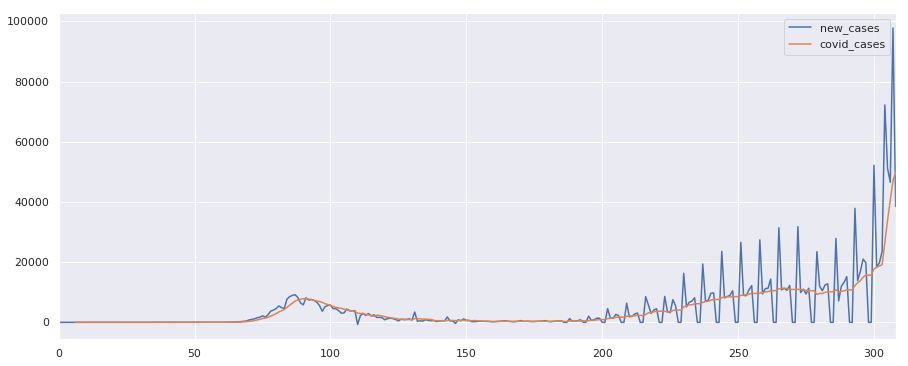

In [15]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [16]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-11-03,2020-11-03,ES,V1,214,1.2.840.10045.4.3.2,96a28135-5ea6-468d-2bb6-0c55b41386d7,2673936,131,0,ES
1,2020-11-03,2020-11-03,ES,V1,214,1.2.840.10045.4.3.2,369426f9-6bf4-5e94-21d6-0778962d6608,2673936,126,0,ES
2,2020-11-03,2020-11-03,ES,V1,214,1.2.840.10045.4.3.2,725a99b7-5a4d-7694-262f-b0f2dddcaf09,2673936,126,0,ES
3,2020-11-03,2020-11-03,ES,V1,214,1.2.840.10045.4.3.2,d7ea36b4-a788-1a34-e5f6-55b0343864e9,2673936,126,0,ES
4,2020-11-03,2020-11-03,ES,V1,214,1.2.840.10045.4.3.2,74cd6a8f-f3ed-0cef-8bd0-659e701b918f,2673936,124,0,ES


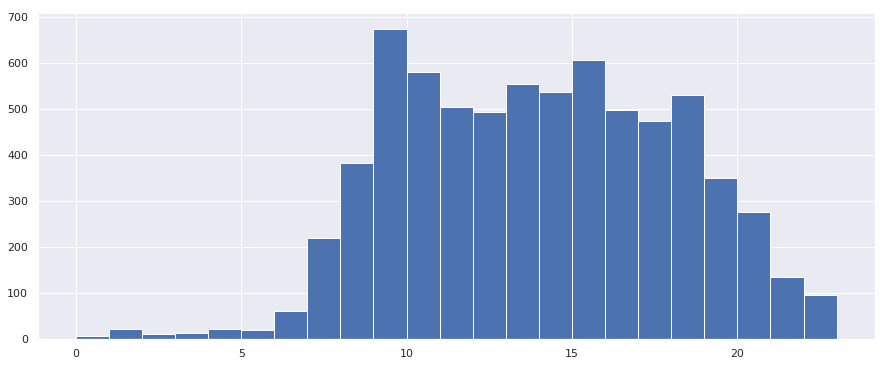

In [17]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

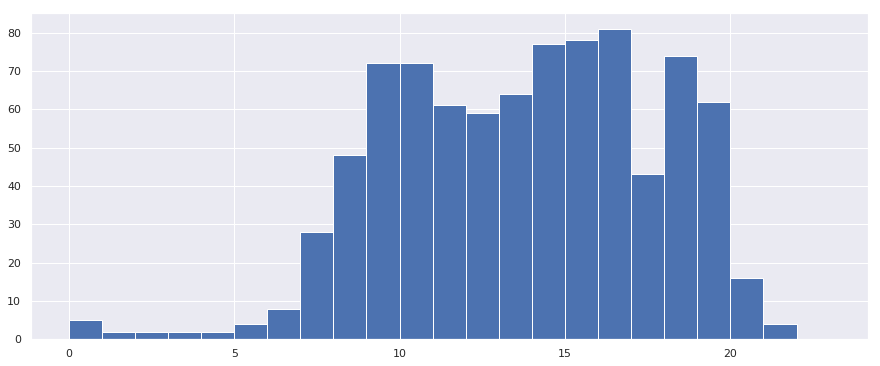

In [18]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [19]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-11-03,ES,96a28135-5ea6-468d-2bb6-0c55b41386d7
1,2020-11-03,ES,369426f9-6bf4-5e94-21d6-0778962d6608
2,2020-11-03,ES,725a99b7-5a4d-7694-262f-b0f2dddcaf09
3,2020-11-03,ES,d7ea36b4-a788-1a34-e5f6-55b0343864e9
4,2020-11-03,ES,74cd6a8f-f3ed-0cef-8bd0-659e701b918f


In [20]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'BE@TST', 'MT', 'PT', 'DK', 'BE', 'ES@PRE', 'CH', 'DE', 'IT', 'ES']

In [21]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                    \
region                                  BE BE@TST    CH    DE   DK  EE    ES   
sample_date                                                                    
2020-11-03                               0      0   557     0    0   0   280   
2020-11-02                               0      0  1686     0  203  10  1589   
2020-11-01                             158     43  2433  1696  398  20  3394   
2020-10-31                             313     40  3081  3035  533  22  4942   
2020-10-30                             614     51  3840  4830  693  27  6935   

                                    
region      ES@PRE    IT   MT   PT  
sample_date                         
2020-11-03       5    23    0    0  
2020-11-02     151  1874  109   97  
2020-11-01     401  3412  114  166  
2020-10-31     644  4765  119  205  
2020-10-30     905  6514  127  249

In [22]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-22-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-22-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-22-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                                 \
region_x                   BE BE@TST        CH        DE   DK   EE        ES   
region_y                                                                       
BE                        NaN    0.0  0.000000  0.000000  0.0  0.0  0.000000   
BE@TST                    0.0    NaN  0.000000  0.000000  0.0  0.0  0.000000   
CH                        0.0    0.0       NaN  0.000082  0.0  0.0  0.000071   
DE                        0.0    0.0  0.000171       NaN  0.0  0.0  0.763437   
DK                        0.0    0.0  0.000000  0.000000  NaN  0.0  0.000000   
EE                        0.0    0.0  0.000000  0.000000  0.0  NaN  0.000000   
ES                        0.0    0.0  0.000171  0.883244  0.0  0.0       NaN   
ES@PRE                    0.0    0.0  0.000000  0.000000  0.0  0.0  0.000071   
IT                        0.0    0.0  0.000171  0.910347  0.0  0.0  0.897894   
MT                        0.0    0.0  0.000000  0.000000  0.0  0.0  0.000000   
PT                        0.0    0.0  0.000000  0.000000  0.0  0.0  0.000000   

                                        
region_x    ES@PRE        IT   MT   PT  
region_y                                
BE        0.000000  0.000000  0.0  0.0  
BE@TST    0.000000  0.000000  0.0  0.0  
CH        0.000000  0.000072  0.0  0.0  
DE        0.000000  0.806726  0.0  0.0  
DK        0.000000  0.000000  0.0  0.0  
EE        0.000000  0.000000  0.0  0.0  
ES        0.000525  0.920559  0.0  0.0  
ES@PRE         NaN  0.000000  0.0  0.0  
IT        0.000000       NaN  0.0  0.0  
MT        0.000000  0.000000  NaN  0.0  
PT        0.000000  0.000000  0.0  NaN

In [23]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['EE', 'BE@TST', 'MT', 'PT', 'DK', 'BE', 'ES@PRE', 'CH', 'DE', 'IT']

In [24]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-11-03,280
2020-11-02,1589
2020-11-01,3394
2020-10-31,4942
2020-10-30,6935


### Dump API TEKs

In [25]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-21,BE,"[00e97a4e-7285-22f5-6258-99e70721d438, 01c18bf...",2020-11-03,2020-11-03@23
1,2020-10-21,BE@TST,"[0e9bbeb5-e782-60b3-9834-8bbb428030f7, 100fc32...",2020-11-03,2020-11-03@23
2,2020-10-21,CH,"[770696d4-0e62-5546-f1fe-61ae62769500, bdb4127...",2020-11-03,2020-11-03@23
3,2020-10-21,DE,"[0009a004-7fbc-849e-81a7-74515c470719, 0021bc8...",2020-11-03,2020-11-03@23
4,2020-10-21,DK,"[25349b63-8817-574b-3775-064c3994e157, 90c3e7a...",2020-11-03,2020-11-03@23


### Load TEK Dumps

In [26]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [27]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-21,"[6295dc72-cd55-fd90-be0c-0b0f3b98f97d, 23f8bbc...",2020-11-03,NaN
17,ES,2020-10-22,"[ff7d2d99-10a2-2116-4711-6dcf632d4ca3, f9300f7...",2020-11-03,NaN
28,ES,2020-10-23,"[acc6039e-6919-8042-19ba-e04f2579c1e8, 7837e50...",2020-11-03,NaN
39,ES,2020-10-24,"[b32b5f5c-15cc-ba72-59d3-d70b86b6d842, 448c876...",2020-11-03,NaN
50,ES,2020-10-25,"[b00901d5-6c93-28a7-a319-ea69d47e1fa5, 3071e3e...",2020-11-03,NaN


In [28]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-11-03,280
2020-11-02,1589
2020-11-01,3394
2020-10-31,4942
2020-10-30,6935


### Daily New TEKs

In [29]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{80a0f6bc-fa55-a6c2-6a58-e50d3d7c7d63, f7a2707..."
2020-08-30,"{80a0f6bc-fa55-a6c2-6a58-e50d3d7c7d63, f7a2707..."
2020-08-31,"{80a0f6bc-fa55-a6c2-6a58-e50d3d7c7d63, f7a2707..."
2020-09-01,"{80a0f6bc-fa55-a6c2-6a58-e50d3d7c7d63, f7a2707..."
2020-09-02,"{80a0f6bc-fa55-a6c2-6a58-e50d3d7c7d63, f7a2707..."


In [30]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-30-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [31]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
50,2020-11-03,2020-10-25,1448,9
39,2020-11-03,2020-10-24,1414,10
28,2020-11-03,2020-10-23,1388,11
17,2020-11-03,2020-10-22,1354,12
6,2020-11-03,2020-10-21,1310,13


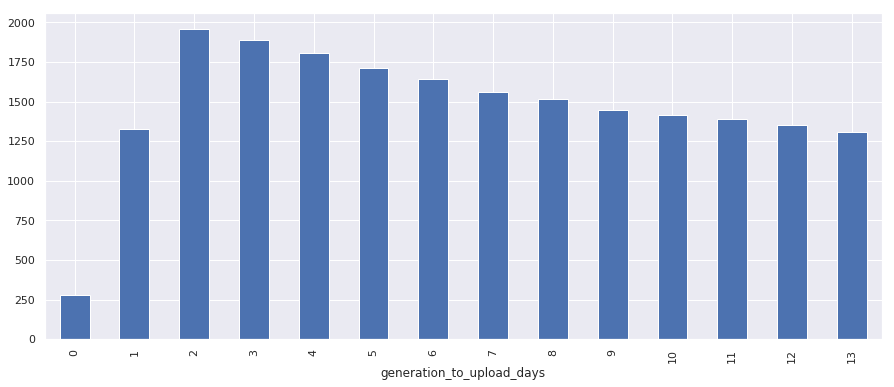

In [32]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [33]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-11-03,280,1325,1961,1888,1809,1711,1642,1564,1519,1448,1414,1388,1354,1310
2020-11-02,264,1156,1711,1629,1500,1415,1314,1250,1195,1163,1129,1100,1072,1029
2020-11-01,277,1038,1842,1654,1495,1375,1302,1241,1196,1168,1123,1075,1046,1016
2020-10-31,305,1273,2163,1934,1766,1671,1578,1507,1461,1416,1370,1326,1292,1266
2020-10-30,382,1743,4126,6104,7567,8436,9104,10138,9629,9129,8815,8563,8326,8153


In [34]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
62,2020-10-30,100215.0
63,2020-10-31,20328.0
64,2020-11-01,16848.0
65,2020-11-02,16927.0
66,2020-11-03,20613.0


In [35]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
141,2020-11-03,280
141,2020-11-02,264
142,2020-11-01,277
141,2020-10-31,305
142,2020-10-30,382


In [36]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == shared_diagnosis_generation_to_upload_days] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
127,2020-11-03,1961
127,2020-11-02,1711
127,2020-11-01,1842
127,2020-10-31,2163
127,2020-10-30,4126


### Hourly New TEKs

In [37]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-21,"[6295dc72-cd55-fd90-be0c-0b0f3b98f97d, 23f8bbc...",2020-11-03,2020-11-03@23
17,ES,2020-10-22,"[ff7d2d99-10a2-2116-4711-6dcf632d4ca3, f9300f7...",2020-11-03,2020-11-03@23
28,ES,2020-10-23,"[acc6039e-6919-8042-19ba-e04f2579c1e8, 7837e50...",2020-11-03,2020-11-03@23
39,ES,2020-10-24,"[b32b5f5c-15cc-ba72-59d3-d70b86b6d842, 448c876...",2020-11-03,2020-11-03@23
50,ES,2020-10-25,"[b00901d5-6c93-28a7-a319-ea69d47e1fa5, 3071e3e...",2020-11-03,2020-11-03@23


In [38]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-11-02@23,0
1,2020-11-03@00,31
2,2020-11-03@01,0
3,2020-11-03@02,20
4,2020-11-03@03,0


In [39]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2020-11-03 00:00:00,2020-11-03@00,31
2020-11-03 01:00:00,2020-11-03@01,0
2020-11-03 02:00:00,2020-11-03@02,20
2020-11-03 03:00:00,2020-11-03@03,0
2020-11-03 04:00:00,2020-11-03@04,8085


### Data Merge

In [40]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-11-03,280,20613.0
1,2020-11-02,1589,16927.0
2,2020-11-01,3394,16848.0
3,2020-10-31,4942,20328.0
4,2020-10-30,6935,100215.0


In [41]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-11-03,280,20613.0,280.0
1,2020-11-02,1589,16927.0,264.0
2,2020-11-01,3394,16848.0,277.0
3,2020-10-31,4942,20328.0,305.0
4,2020-10-30,6935,100215.0,382.0


In [42]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-11-03,280,20613.0,280.0,1961.0
1,2020-11-02,1589,16927.0,264.0,1711.0
2,2020-11-01,3394,16848.0,277.0,1842.0
3,2020-10-31,4942,20328.0,305.0,2163.0
4,2020-10-30,6935,100215.0,382.0,4126.0


In [43]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-12,3172,3431.0,NaN,NaN,NaN,NaN
1,2020-08-13,7550,3926.0,NaN,NaN,NaN,NaN
2,2020-08-14,5479,4064.0,NaN,NaN,NaN,NaN
3,2020-08-15,0,4064.0,NaN,NaN,NaN,NaN
4,2020-08-16,0,4064.0,NaN,NaN,NaN,NaN


In [44]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,
2020-11-03,38485,49941.0,280.0,20613.0,280.0,1961.0
2020-11-02,97809,47074.0,1589.0,16927.0,264.0,1711.0
2020-11-01,46545,40557.0,3394.0,16848.0,277.0,1842.0
2020-10-31,51184,33908.0,4942.0,20328.0,305.0,2163.0
2020-10-30,72219,26596.0,6935.0,100215.0,382.0,4126.0


In [45]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,
2020-11-03,38485,49941,280,20613,280,1961,10.511474,0.039266
2020-11-02,97809,47074,1589,16927,264,1711,9.893045,0.036347
2020-11-01,46545,40557,3394,16848,277,1842,9.146580,0.045418
2020-10-31,51184,33908,4942,20328,305,2163,9.398058,0.063790
2020-10-30,72219,26596,6935,100215,382,4126,24.288657,0.155136
2020-10-29,23580,19115,9168,1847,397,285,6.480702,0.014910
2020-10-28,19765,18744,11351,1933,406,328,5.893293,0.017499
2020-10-27,18418,18345,13001,988,231,164,6.024390,0.008940
2020-10-26,52188,17696,14276,994,215,145,6.855172,0.008194


In [46]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-11-03,235935,37659,178711,12416,14.393605,0.052625
2020-11-02,204339,50380,159086,10619,14.981260,0.051968
2020-11-01,174961,63067,143153,9053,15.812769,0.051743
2020-10-31,150057,74530,126984,7306,17.380783,0.048688
2020-10-30,131802,84864,107359,5249,20.453229,0.039825


In [47]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 204339,
 'shared_teks_by_generation_date': 50380,
 'shared_teks_by_upload_date': 159086,
 'shared_diagnoses': 10619,
 'teks_per_shared_diagnosis': 14.981260005650249,
 'shared_diagnoses_per_covid_case': 0.051967563705411106}

## Report Results

In [48]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [49]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [50]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-11-03,49941,280,20613,280,1961,10.511474,0.039266
2020-11-02,47074,1589,16927,264,1711,9.893045,0.036347
2020-11-01,40557,3394,16848,277,1842,9.146580,0.045418
2020-10-31,33908,4942,20328,305,2163,9.398058,0.063790
2020-10-30,26596,6935,100215,382,4126,24.288657,0.155136
...,...,...,...,...,...,...,...
2020-08-16,4064,0,0,0,0,0.000000,0.000000
2020-08-15,4064,0,0,0,0,0.000000,0.000000
2020-08-14,4064,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

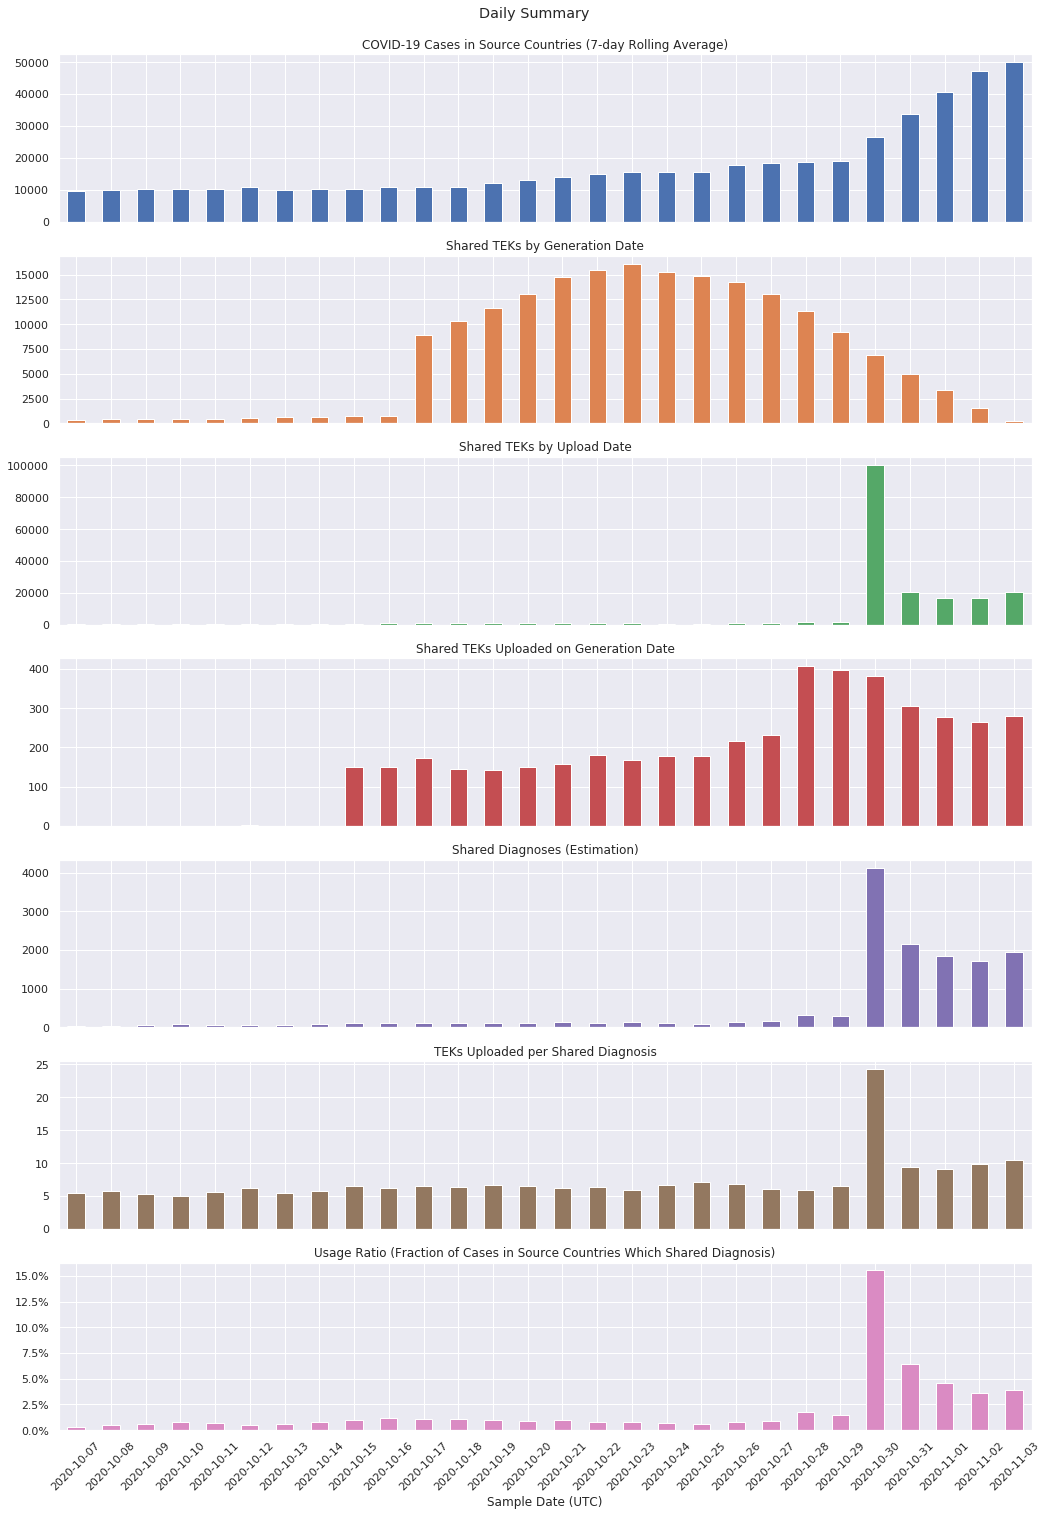

In [51]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [52]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-11-03,280,1325,1961,1888,1809,1711,1642,1564,1519,1448,1414,1388,1354,1310
2020-11-02,264,1156,1711,1629,1500,1415,1314,1250,1195,1163,1129,1100,1072,1029
2020-11-01,277,1038,1842,1654,1495,1375,1302,1241,1196,1168,1123,1075,1046,1016
2020-10-31,305,1273,2163,1934,1766,1671,1578,1507,1461,1416,1370,1326,1292,1266
2020-10-30,382,1743,4126,6104,7567,8436,9104,10138,9629,9129,8815,8563,8326,8153
2020-10-29,397,333,285,237,183,139,82,59,50,30,22,14,10,6
2020-10-28,406,362,328,263,204,138,88,62,35,17,10,7,7,6
2020-10-27,231,187,164,123,98,77,44,28,22,11,3,0,0,0
2020-10-26,215,170,145,124,105,85,51,32,24,18,12,6,5,2


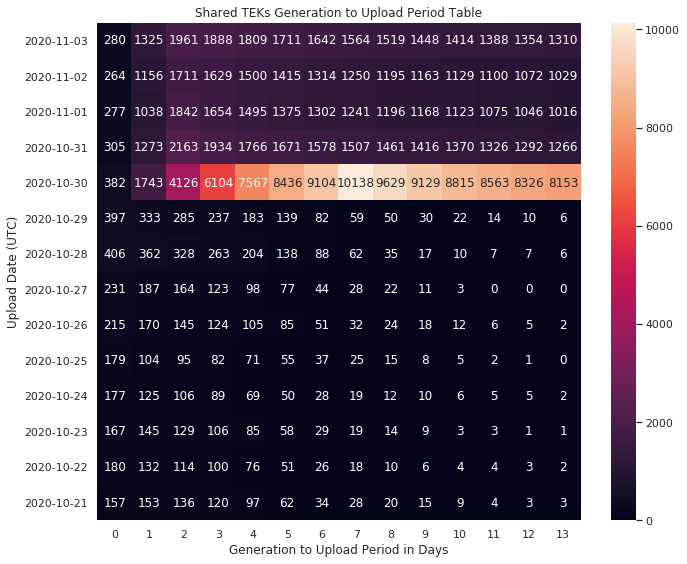

In [53]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(10, 1 + 0.5 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

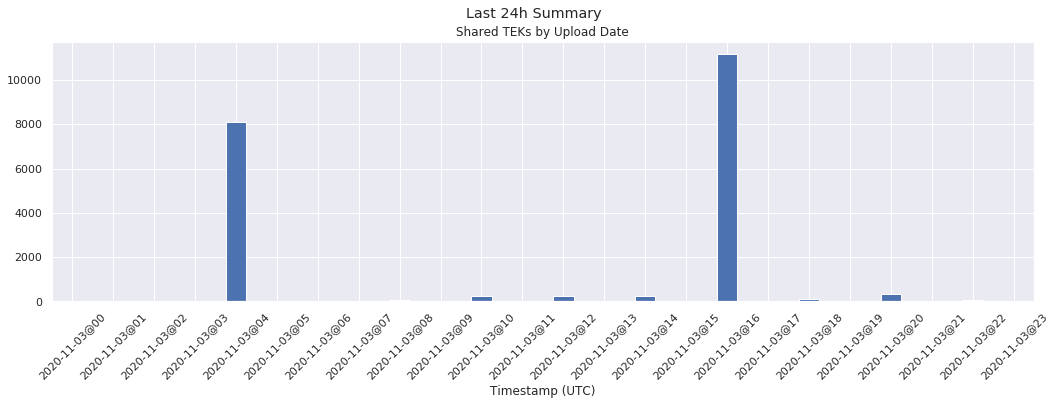

In [54]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [55]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [56]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)

display_brief_source_regions_limit = 2
if len(report_source_regions) <= display_brief_source_regions_limit:
    display_brief_source_regions = display_source_regions
else:
    prefix_countries = ", ".join(report_source_regions[:display_brief_source_regions_limit])
    display_brief_source_regions = f"{len(report_source_regions)} ({prefix_countries}…)"

if len(report_source_regions) == 1:
    display_brief_source_regions_warning_prefix_message = ""
else:
    display_brief_source_regions_warning_prefix_message = "⚠️ "

In [57]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [58]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [59]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [60]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [61]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        {display_brief_source_regions_warning_prefix_message}Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)